In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import importlib
import funs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from kneed import KneeLocator
importlib.reload(funs)
from sklearn.cluster import KMeans

print("PyTorch works")
funs.log("START",level = ("start","Pipeline_1"))


PyTorch works
Pipeline_1


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 32px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 20px;
    margin-bottom: 20px;
    padding: 15px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #ff2954;
    border-bottom: 4px solid #ff2954;
    box-shadow: 0 0 100px rgba(255, 41, 84, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
    Data
 </div>

In [2]:
df_training = pd.read_hdf('parsed_data/segmented_CICIDS2017.h5', key='df_1_scaled')
df_test = pd.read_hdf('parsed_data/merged_CICIDS2017.h5', key='df_scaled')
df_test_labels = pd.read_hdf('parsed_data/merged_CICIDS2017.h5', key='df_labels')

<div style="
    text-align: center;
    font-weight: bold;
    font-size: 32px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 20px;
    margin-bottom: 20px;
    padding: 15px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #ff2954;
    border-bottom: 4px solid #ff2954;
    box-shadow: 0 0 100px rgba(255, 41, 84, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
    Models prep & training
 </div>

<div style="
    text-align: center;
    font-weight: bold;
    font-size: 22px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 10px;
    margin-bottom: 10px;
    padding: 5px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    letter-spacing: 1px;
">
    Isolation Forest
 </div>

In [3]:
IF = IsolationForest(
    n_estimators=250,
    max_samples=8192, 
    contamination= 0.01, #PRAKTYCZNIE NIE ISTOTNE DO PRZEWIDYWAN MODELU, ISTOTNE TYLKO PRZY ZWRACANIU WYNIKOW ZE STATYSTYK
    max_features=1.0, 
    bootstrap=False, 
    n_jobs=None, 
    random_state=33, 
    verbose=1, 
    warm_start=False
)
params_IF = '\n'.join(f'{k}: {v}' for k, v in IF.get_params().items())
funs.log("Parameters IF:\n" + params_IF)

IF.fit(df_training)

Parameters IF:
bootstrap: False
contamination: 0.01
max_features: 1.0
max_samples: 8192
n_estimators: 250
n_jobs: None
random_state: 33
verbose: 1
warm_start: False


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.8s finished


,n_estimators,250
,max_samples,8192
,contamination,0.01
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,33
,verbose,1
,warm_start,False


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 22px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 10px;
    margin-bottom: 10px;
    padding: 5px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    letter-spacing: 1px;
">
    Local Outlaier Factor
 </div>

In [4]:
LOF= LocalOutlierFactor(
    n_neighbors=50,
    algorithm='auto',
    leaf_size=30,
    metric='minkowski',
    p=2,
    metric_params=None,
    contamination='auto',
    novelty=True,
    n_jobs=None
)
params_LOF = '\n'.join(f'{k}: {v}' for k, v in LOF.get_params().items())
funs.log("Parameters LOF:\n" + params_LOF)

LOF.fit(df_training)

Parameters LOF:
algorithm: auto
contamination: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 50
novelty: True
p: 2


,n_neighbors,50
,algorithm,'auto'
,leaf_size,30
,metric,'minkowski'
,p,2
,metric_params,None
,contamination,'auto'
,novelty,True
,n_jobs,None


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 22px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 10px;
    margin-bottom: 10px;
    padding: 5px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    letter-spacing: 1px;
">
    Autoencoder
 </div>

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        # Encoder layers
        self.encoder_1 = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU()
        )
        self.encoder_2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.encoder_3 = nn.Sequential(
            nn.Linear(32, 16)  # bottleneck
        )

        # Decoder layers
        self.decoder_1 = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU()
        )
        self.decoder_2 = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU()
        )
        self.output_layer = nn.Linear(64, input_dim)

    def forward(self, x):
        x1 = self.encoder_1(x)       
        x2 = self.encoder_2(x1)      
        x3 = self.encoder_3(x2)      

        d1 = self.decoder_1(x3) + x2  
        d2 = self.decoder_2(d1) + x1  
        output = self.output_layer(d2)  

        return output



X = torch.tensor(df_training.values, dtype=torch.float32)

# Wrap into dataset and loader
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

input_dim = df_training.shape[1]  # number of features
model_A_1 = Autoencoder(input_dim)

criterion = nn.MSELoss()  # Mean Squared Error: good for reconstruction tasks
optimizer = torch.optim.Adam(model_A_1.parameters(), lr=1e-3)


num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        batch_X = batch[0]

        # Forward pass
        outputs = model_A_1(batch_X)
        loss = criterion(outputs, batch_X)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

Epoch [1/20], Loss: 207.2547
Epoch [2/20], Loss: 176.1922
Epoch [3/20], Loss: 183.1357
Epoch [4/20], Loss: 189.4172
Epoch [5/20], Loss: 187.9328
Epoch [6/20], Loss: 158.8084
Epoch [7/20], Loss: 95.0605
Epoch [8/20], Loss: 92.0766
Epoch [9/20], Loss: 108.1528
Epoch [10/20], Loss: 104.7567
Epoch [11/20], Loss: 54.2499
Epoch [12/20], Loss: 57.9004
Epoch [13/20], Loss: 47.8503
Epoch [14/20], Loss: 57.6764
Epoch [15/20], Loss: 34.4429
Epoch [16/20], Loss: 47.7204
Epoch [17/20], Loss: 46.0496
Epoch [18/20], Loss: 32.0739
Epoch [19/20], Loss: 29.1863
Epoch [20/20], Loss: 41.6977


<div style="
    text-align: center;
    font-weight: bold;
    font-size: 32px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 20px;
    margin-bottom: 20px;
    padding: 15px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #ff2954;
    border-bottom: 4px solid #ff2954;
    box-shadow: 0 0 100px rgba(255, 41, 84, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
    Testing
 </div>

<div style="
    text-align: center;
    font-weight: bold;
    font-size: 22px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 10px;
    margin-bottom: 10px;
    padding: 5px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    letter-spacing: 1px;
">
    Isolation Forest
 </div>

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.9s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   16.2s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.8s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   16.0s finished


Isolation_Forest
Detection distribution anomaly/normal: 15.7367% / 84.2633%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 263903
Normal traffic: 1413090


/root/Anomaly_Detection/funs.py:257: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/root/Anomaly_Detection/venv_AD/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


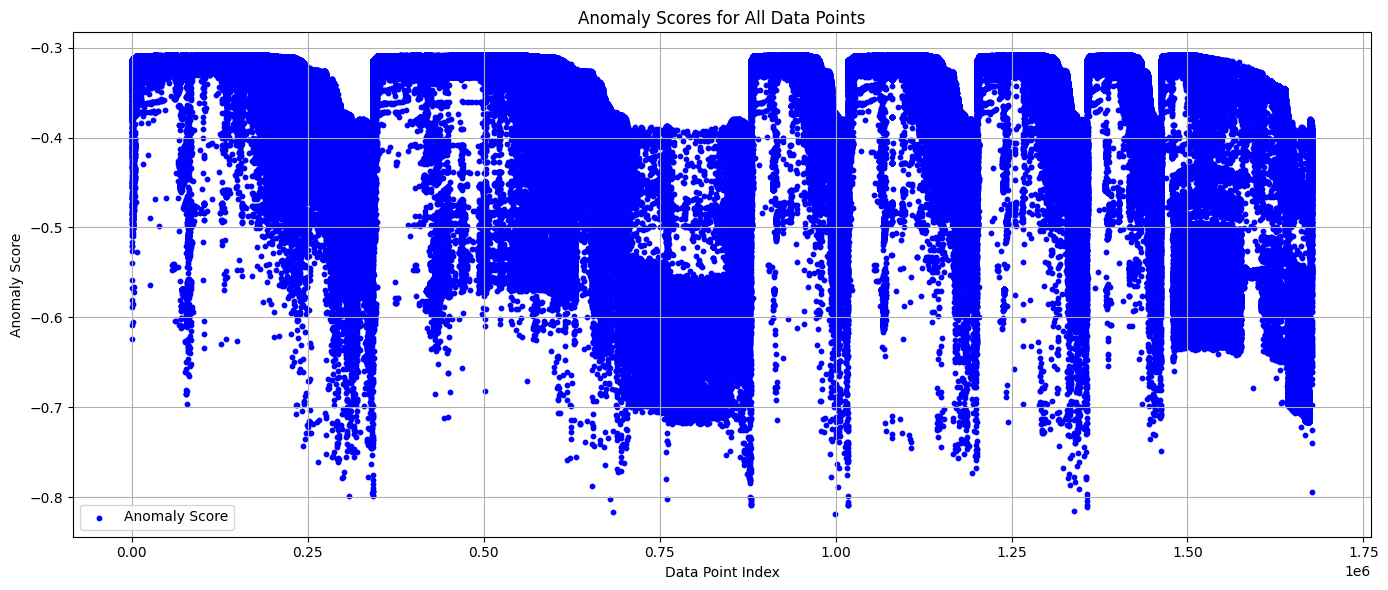

Isolation_Forest
Number of flows in df_test_IF: 1676993
Correct data: 
Real number of anomalies in df_test_IF: 335370
Procentage of anomlys in dataset: 19.9983%
Predicted data: 
Number of DETECTED anomalies in df_test_IF: 263903
Procentage of anomlys in dataset: 15.7367%

Number of correct predictions(TP): 228710
Number of wrong predyctions(FP): 35193
Accuracy of predictions: 91.5412%
Sensitivity of predictions: 68.1963%
Precision of predictions: 86.6644%
F - mesure - harmonic-mean of precision and sensitivity: 76.3292%


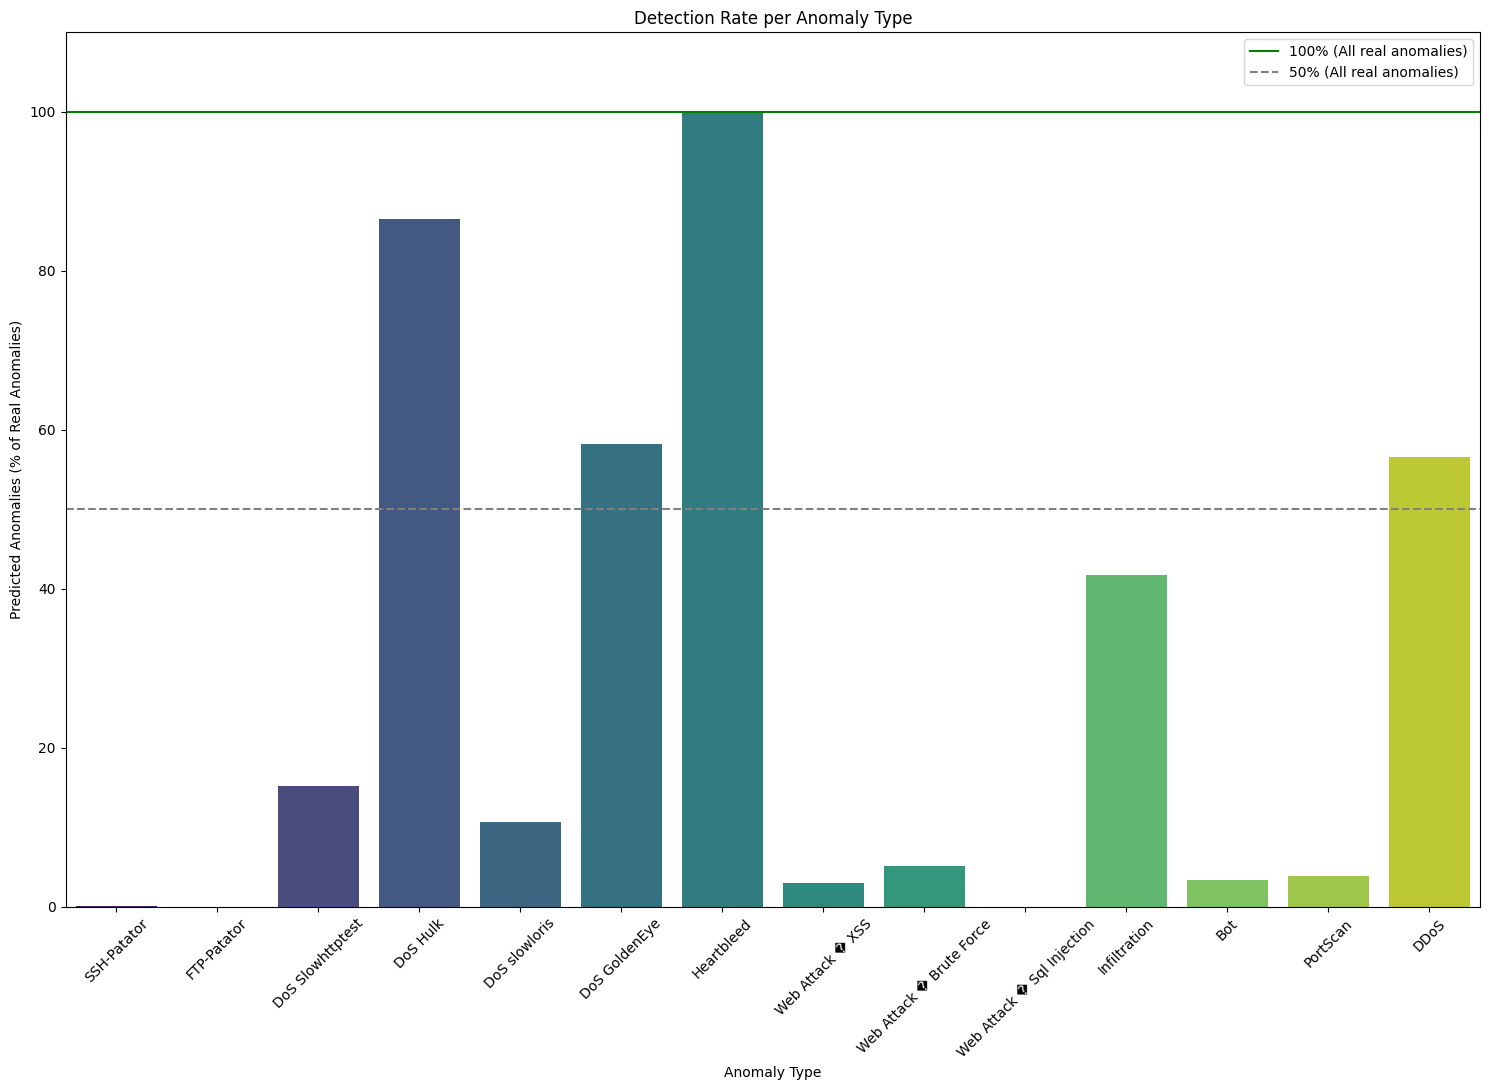

Detection rate by attack type:
Name: SSH-Patator, Detected: 0.0634%
Name: FTP-Patator, Detected: 0.0%
Name: DoS Slowhttptest, Detected: 15.2286%
Name: DoS Hulk, Detected: 86.4726%
Name: DoS slowloris, Detected: 10.5909%
Name: DoS GoldenEye, Detected: 58.1558%
Name: Heartbleed, Detected: 100.0%
Name: Web Attack � XSS, Detected: 2.9141%
Name: Web Attack � Brute Force, Detected: 5.1156%
Name: Web Attack � Sql Injection, Detected: 0.0%
Name: Infiltration, Detected: 41.6667%
Name: Bot, Detected: 3.2909%
Name: PortScan, Detected: 3.8482%
Name: DDoS, Detected: 56.5677%


In [7]:
df_scaled_result_check_IF = funs.test_IF_model(IF,df_test,df_test_labels, name="df_test_IF")

<div style="
    text-align: center;
    font-weight: bold;
    font-size: 22px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 10px;
    margin-bottom: 10px;
    padding: 5px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    letter-spacing: 1px;
">
    Local Outlaier Factor
 </div>

/root/Anomaly_Detection/venv_AD/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/root/Anomaly_Detection/venv_AD/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Local_Outlier_Factor
Detection distribution anomaly/normal: 35.6408% / 64.3592%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 597693
Normal traffic: 1079300


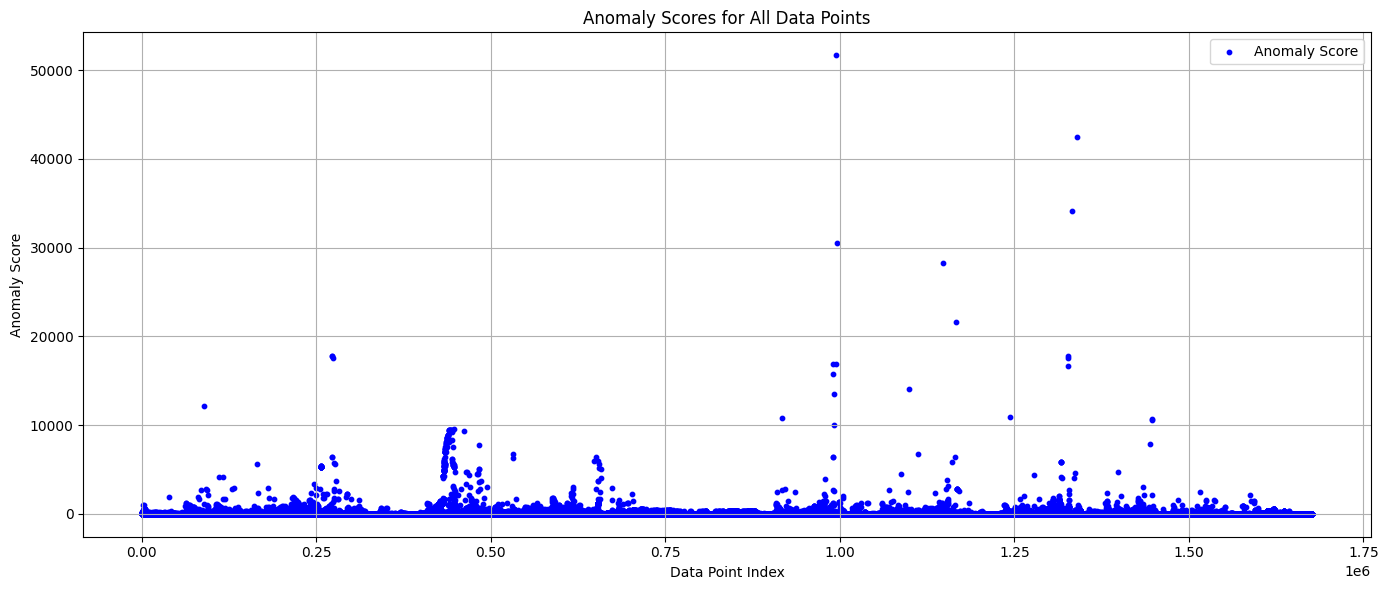

Local_Outlier_Factor
Number of flows in df_test_LOC: 1676993
Correct data: 
Real number of anomalies in df_test_LOC: 335370
Procentage of anomlys in dataset: 19.9983%
Predicted data: 
Number of DETECTED anomalies in df_test_LOC: 597693
Procentage of anomlys in dataset: 35.6408%

Number of correct predictions(TP): 298169
Number of wrong predyctions(FP): 299524
Accuracy of predictions: 79.9209%
Sensitivity of predictions: 88.9075%
Precision of predictions: 49.8866%
F - mesure - harmonic-mean of precision and sensitivity: 63.9119%


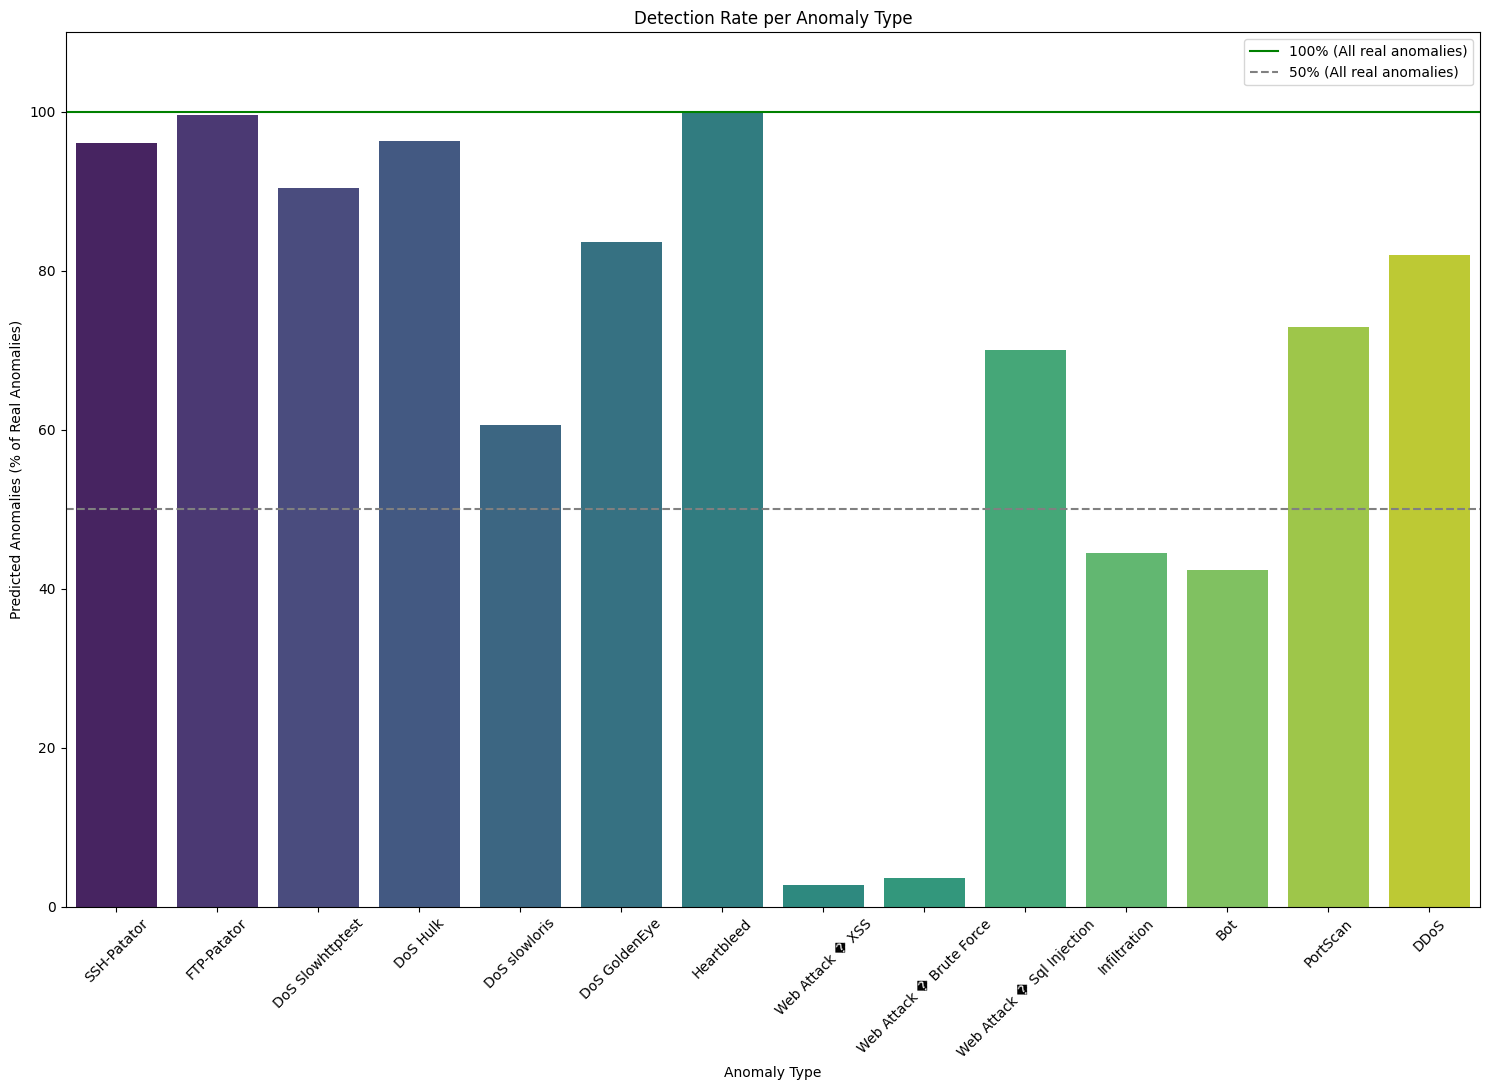

Detection rate by attack type:
Name: SSH-Patator, Detected: 96.0355%
Name: FTP-Patator, Detected: 99.5953%
Name: DoS Slowhttptest, Detected: 90.4343%
Name: DoS Hulk, Detected: 96.278%
Name: DoS slowloris, Detected: 60.5537%
Name: DoS GoldenEye, Detected: 83.5716%
Name: Heartbleed, Detected: 100.0%
Name: Web Attack � XSS, Detected: 2.7607%
Name: Web Attack � Brute Force, Detected: 3.5739%
Name: Web Attack � Sql Injection, Detected: 70.0%
Name: Infiltration, Detected: 44.4444%
Name: Bot, Detected: 42.3336%
Name: PortScan, Detected: 72.9589%
Name: DDoS, Detected: 82.0237%


In [8]:
df_scaled_result_check_LOF = funs.test_LOF_model(LOF,df_test,df_test_labels, name="df_test_LOC")

<div style="
    text-align: center;
    font-weight: bold;
    font-size: 22px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 10px;
    margin-bottom: 10px;
    padding: 5px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    letter-spacing: 1px;
">
    Autoencoder
 </div>

83
Autoencoder
Detection distribution anomaly/normal: 17.0000% / 83.0000%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 285089
Normal traffic: 1391904


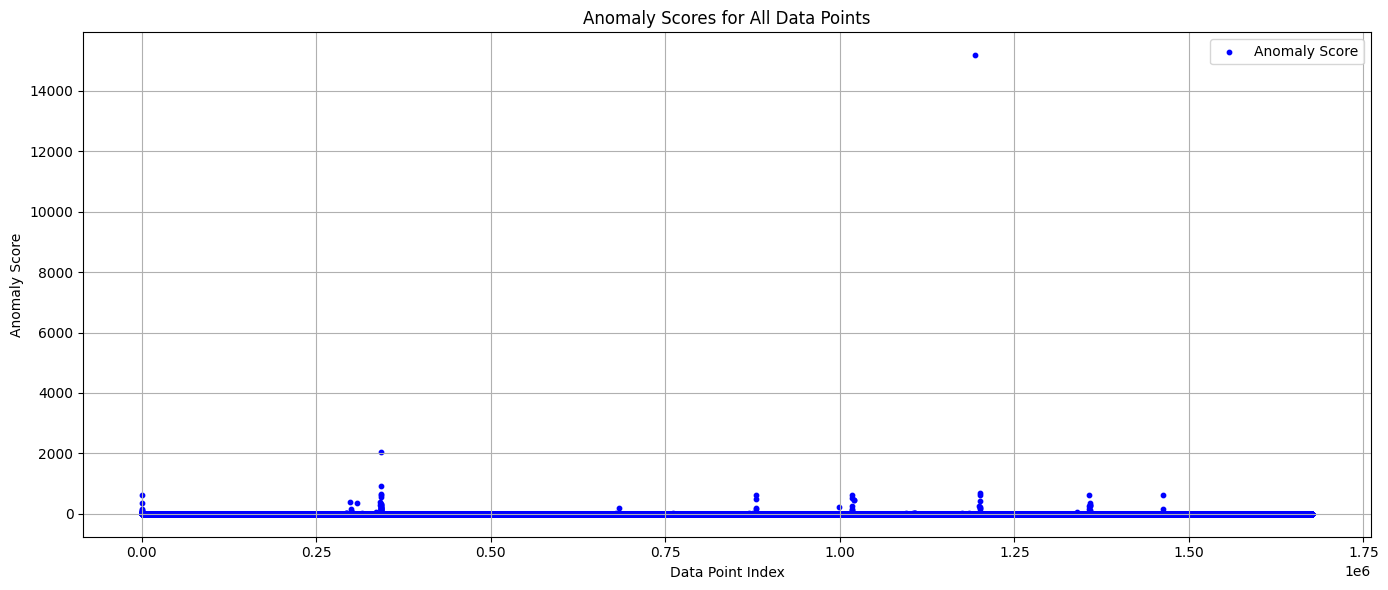

Autoencoder
Number of flows in df_test_AF: 1676993
Correct data: 
Real number of anomalies in df_test_AF: 335370
Procentage of anomlys in dataset: 19.9983%
Predicted data: 
Number of DETECTED anomalies in df_test_AF: 285089
Procentage of anomlys in dataset: 17.0000%

Number of correct predictions(TP): 241773
Number of wrong predyctions(FP): 43316
Accuracy of predictions: 91.8358%
Sensitivity of predictions: 72.0914%
Precision of predictions: 84.8061%
F - mesure - harmonic-mean of precision and sensitivity: 77.9336%


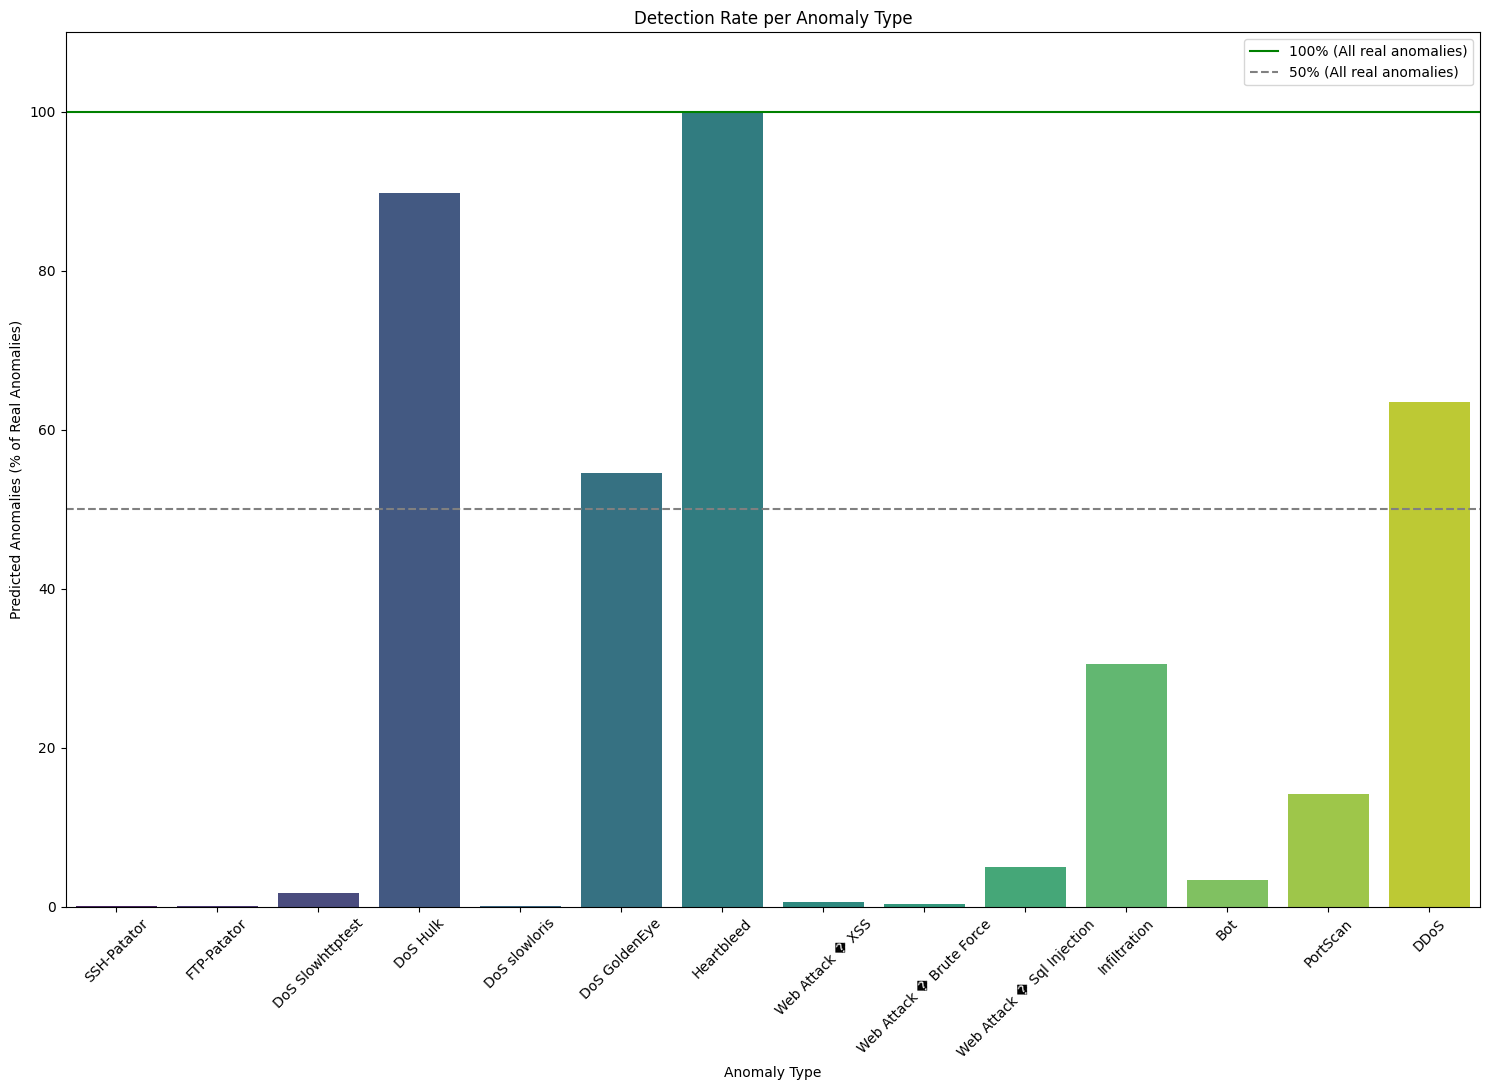

Detection rate by attack type:
Name: SSH-Patator, Detected: 0.0634%
Name: FTP-Patator, Detected: 0.0337%
Name: DoS Slowhttptest, Detected: 1.741%
Name: DoS Hulk, Detected: 89.7864%
Name: DoS slowloris, Detected: 0.0186%
Name: DoS GoldenEye, Detected: 54.5764%
Name: Heartbleed, Detected: 100.0%
Name: Web Attack � XSS, Detected: 0.6135%
Name: Web Attack � Brute Force, Detected: 0.2803%
Name: Web Attack � Sql Injection, Detected: 5.0%
Name: Infiltration, Detected: 30.5556%
Name: Bot, Detected: 3.2909%
Name: PortScan, Detected: 14.1966%
Name: DDoS, Detected: 63.5139%


In [10]:
X_test_tensor = torch.tensor(df_test.values, dtype=torch.float32)

with torch.no_grad():
    reconstructed = model_A_1(X_test_tensor)

reconstruction_error = F.mse_loss(reconstructed, X_test_tensor, reduction='none')
reconstruction_error = reconstruction_error.mean(dim=1).numpy() 

threshold = 100 - round((reconstruction_error.sum() / len(reconstruction_error)) * 100 )

print(threshold)

threshold = np.percentile(reconstruction_error,threshold)  
predictions = (reconstruction_error > threshold).astype(int)

df_AE = pd.DataFrame()
df_AE["anomaly_score"] = reconstruction_error
df_AE["prediction"] = np.where(df_AF["anomaly_score"] > threshold, -1, 1)
df_AE["Label"] = df_test_labels.values


df_scaled_result_check_AE = funs.test_model(name="df_test_AF", level=["start","Autoencoder"],ready = df_AE, flag = True)

<div style="
    text-align: center;
    font-weight: bold;
    font-size: 32px;
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    margin-top: 20px;
    margin-bottom: 20px;
    padding: 15px 0;
    color: #ffffff;
    background: linear-gradient(90deg, #0f0f0f 0%, #1e1e1e 100%);
    border-top: 4px solid #ff2954;
    border-bottom: 4px solid #ff2954;
    box-shadow: 0 0 100px rgba(255, 41, 84, 0.3), 0 2px 10px rgba(0,0,0,0.6);
    letter-spacing: 1px;
">
    Results
 </div>

/tmp/ipykernel_449503/1340048789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers.rename(columns={'prediction': 'IF_prediction', "anomaly_score": "IF_anomaly_score"}, inplace=True)
/tmp/ipykernel_449503/1340048789.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers[["LOF_prediction", "LOF_anomaly_score"]] = df_scaled_result_check_LOF[["prediction", "anomaly_score"]]
/tmp/ipykernel_449503/1340048789.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Autoencoder
Detection distribution anomaly/normal: 14.7501% / 85.2499%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 247358
Normal traffic: 1429635


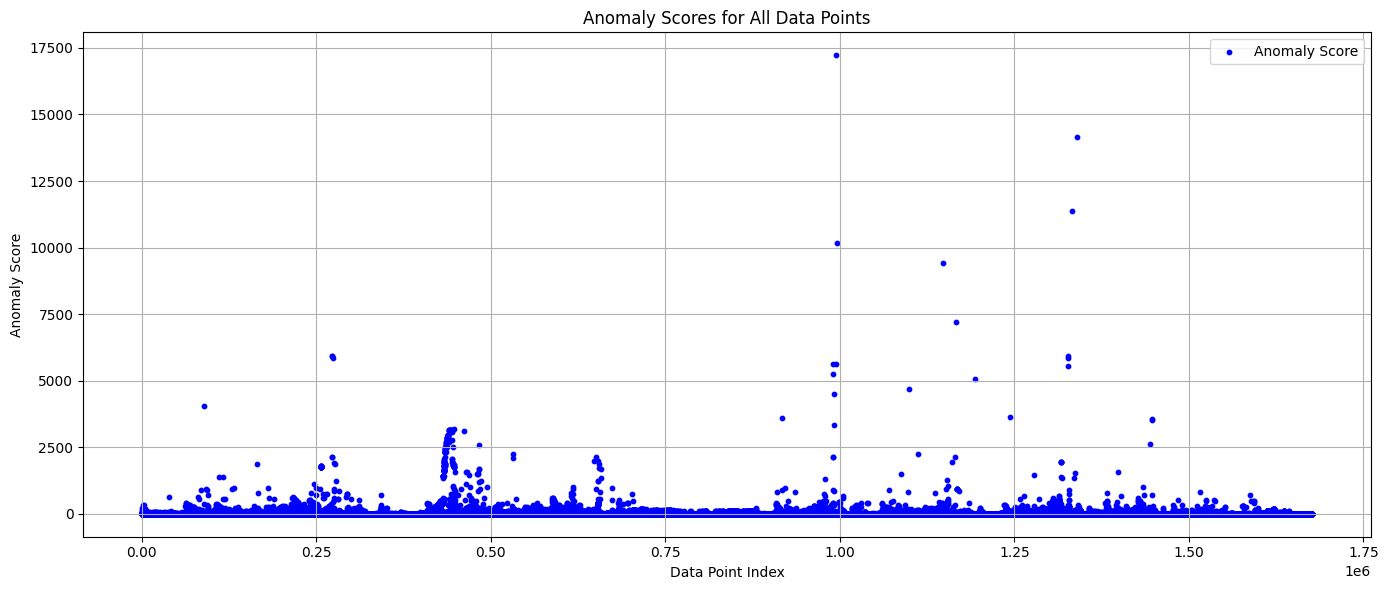

Autoencoder
Number of flows in df_test_all: 1676993
Correct data: 
Real number of anomalies in df_test_all: 335370
Procentage of anomlys in dataset: 19.9983%
Predicted data: 
Number of DETECTED anomalies in df_test_all: 247358
Procentage of anomlys in dataset: 14.7501%

Number of correct predictions(TP): 225501
Number of wrong predyctions(FP): 21857
Accuracy of predictions: 92.1451%
Sensitivity of predictions: 67.2395%
Precision of predictions: 91.1638%
F - mesure - harmonic-mean of precision and sensitivity: 77.3949%


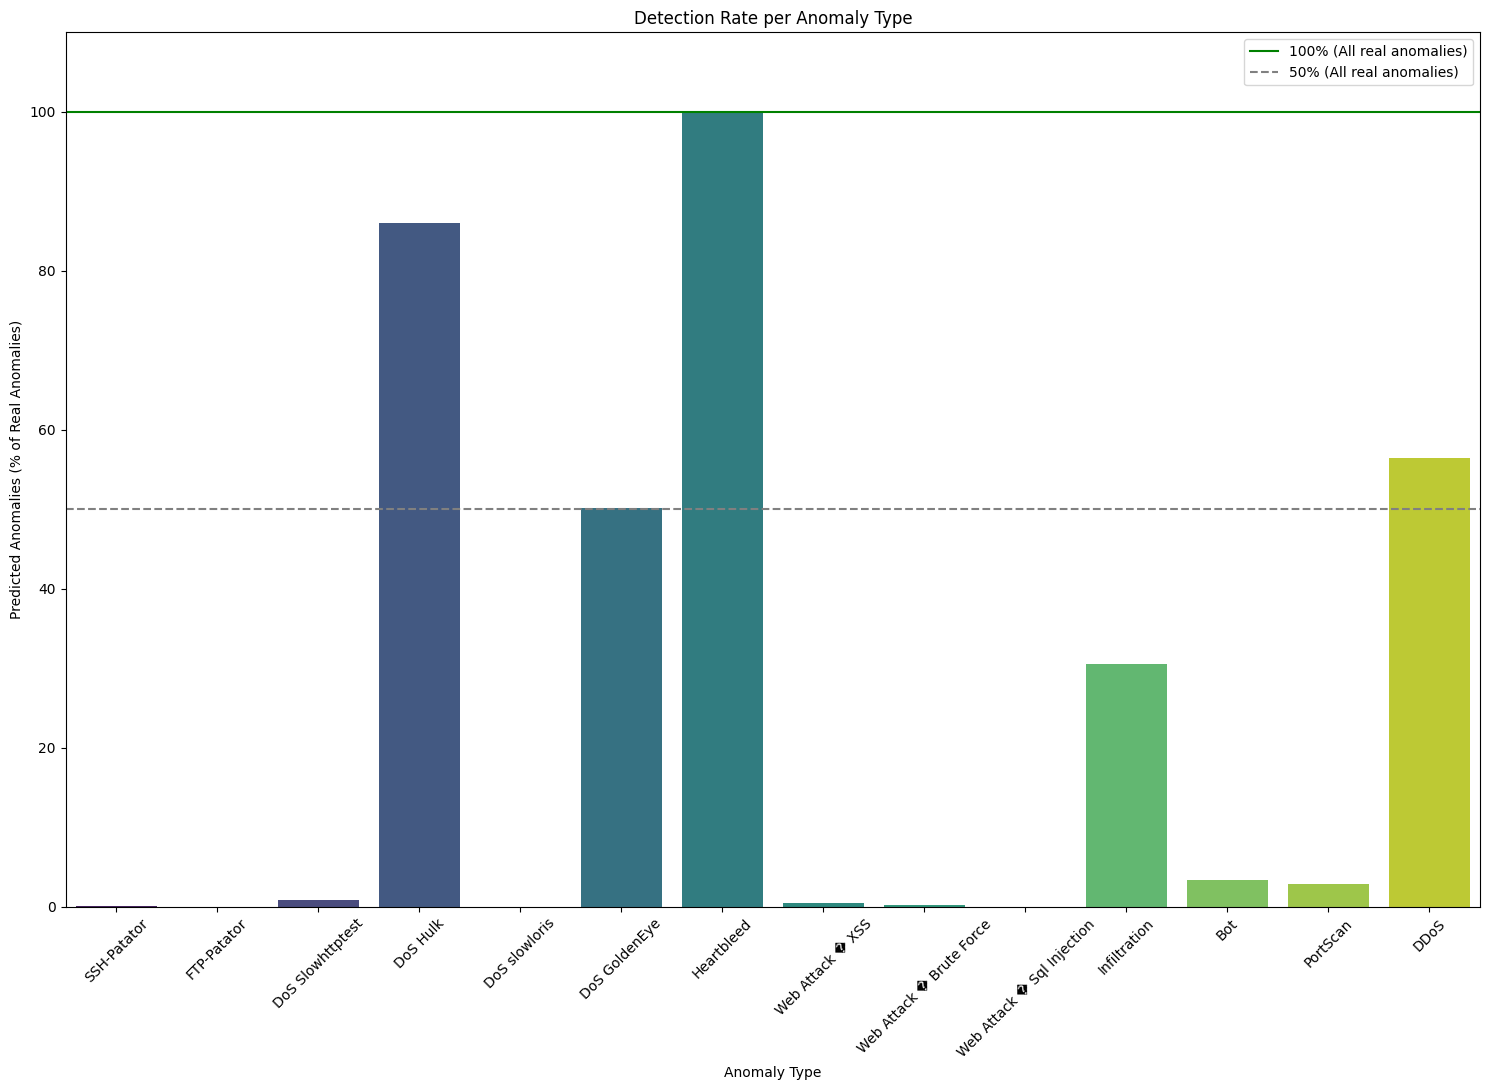

Detection rate by attack type:
Name: SSH-Patator, Detected: 0.0634%
Name: FTP-Patator, Detected: 0.0%
Name: DoS Slowhttptest, Detected: 0.8227%
Name: DoS Hulk, Detected: 85.9696%
Name: DoS slowloris, Detected: 0.0%
Name: DoS GoldenEye, Detected: 50.1702%
Name: Heartbleed, Detected: 100.0%
Name: Web Attack � XSS, Detected: 0.4601%
Name: Web Attack � Brute Force, Detected: 0.2102%
Name: Web Attack � Sql Injection, Detected: 0.0%
Name: Infiltration, Detected: 30.5556%
Name: Bot, Detected: 3.2909%
Name: PortScan, Detected: 2.8081%
Name: DDoS, Detected: 56.4974%


,IF_prediction,IF_anomaly_score,LOF_prediction,LOF_anomaly_score,AE_prediction,AE_anomaly_score,prediction,anomaly_score,Label
0,1,-0.313946,-1,2.508200,1,0.049511,1,0.747921,BENIGN
1,1,-0.318780,1,-0.532885,1,0.036191,1,-0.271825,BENIGN
2,1,-0.402547,1,-0.460139,-1,0.258989,1,-0.201232,BENIGN
3,1,-0.313946,-1,2.449890,1,0.049511,1,0.728485,SSH-Patator
4,1,-0.331743,1,-0.498932,1,0.078927,1,-0.250583,FTP-Patator
...,...,...,...,...,...,...,...,...,...
1676988,-1,-0.555335,1,-0.162555,1,0.155962,1,-0.187309,BENIGN
1676989,-1,-0.555458,1,-0.162014,1,0.156062,1,-0.187137,BENIGN
1676990,1,-0.440034,-1,1.685218,1,0.054260,1,0.433148,BENIGN
1676991,1,-0.404131,1,-0.504959,1,0.099845,1,-0.269748,BENIGN


In [15]:
df_af_outliers = df_scaled_result_check_AF[df_scaled_result_check_AF["prediction"] == -1]
df_if_outliers = df_scaled_result_check_IF[df_scaled_result_check_IF["prediction"] == -1]
df_lof_outliers = df_scaled_result_check_LOF[df_scaled_result_check_LOF["prediction"] == -1]

df_result = pd.concat([df_af_outliers, df_if_outliers, df_lof_outliers], ignore_index=True)
df_result = df_result.drop_duplicates()

funs.test_model(name="df_test_all", level=["start","Autoencoder"],ready = df_result, flag = True)

/tmp/ipykernel_449503/2238285682.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers.rename(columns={'prediction': 'IF_prediction', "anomaly_score": "IF_anomaly_score"}, inplace=True)
/tmp/ipykernel_449503/2238285682.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_outliers[["LOF_prediction", "LOF_anomaly_score"]] = df_scaled_result_check_LOF[["prediction", "anomaly_score"]]
/tmp/ipykernel_449503/2238285682.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

Autoencoder
Detection distribution anomaly/normal: 37.0681% / 62.9319%
!!! Wyniki pokazuje dopasowanie contamination (wyciagania wnioskow z gotowego produktu pracy modelu) NIE DCHYLENIA NORMALNY/ANOMALYJNY ruch sieciowy !!!
Anomaly detected: 621629
Normal traffic: 1055364


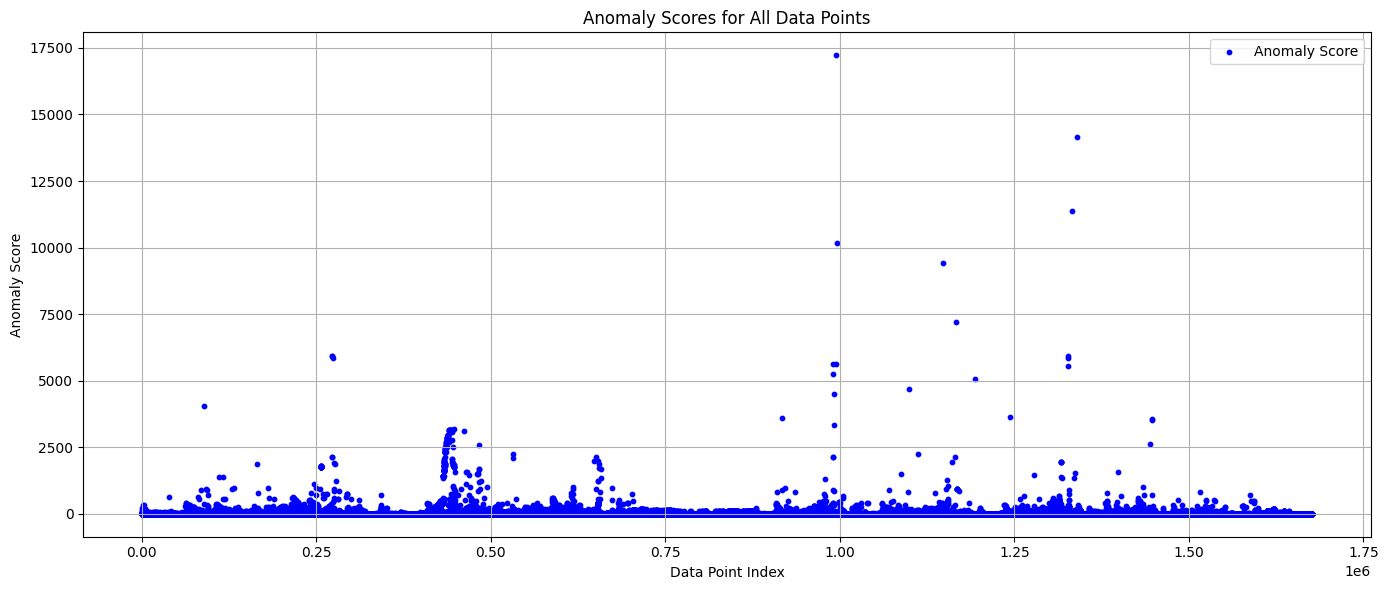

Autoencoder
Number of flows in df_test_all: 1676993
Correct data: 
Real number of anomalies in df_test_all: 335370
Procentage of anomlys in dataset: 19.9983%
Predicted data: 
Number of DETECTED anomalies in df_test_all: 621629
Procentage of anomlys in dataset: 37.0681%

Number of correct predictions(TP): 298966
Number of wrong predyctions(FP): 322663
Accuracy of predictions: 78.5886%
Sensitivity of predictions: 89.1451%
Precision of predictions: 48.0940%
F - mesure - harmonic-mean of precision and sensitivity: 62.4799%


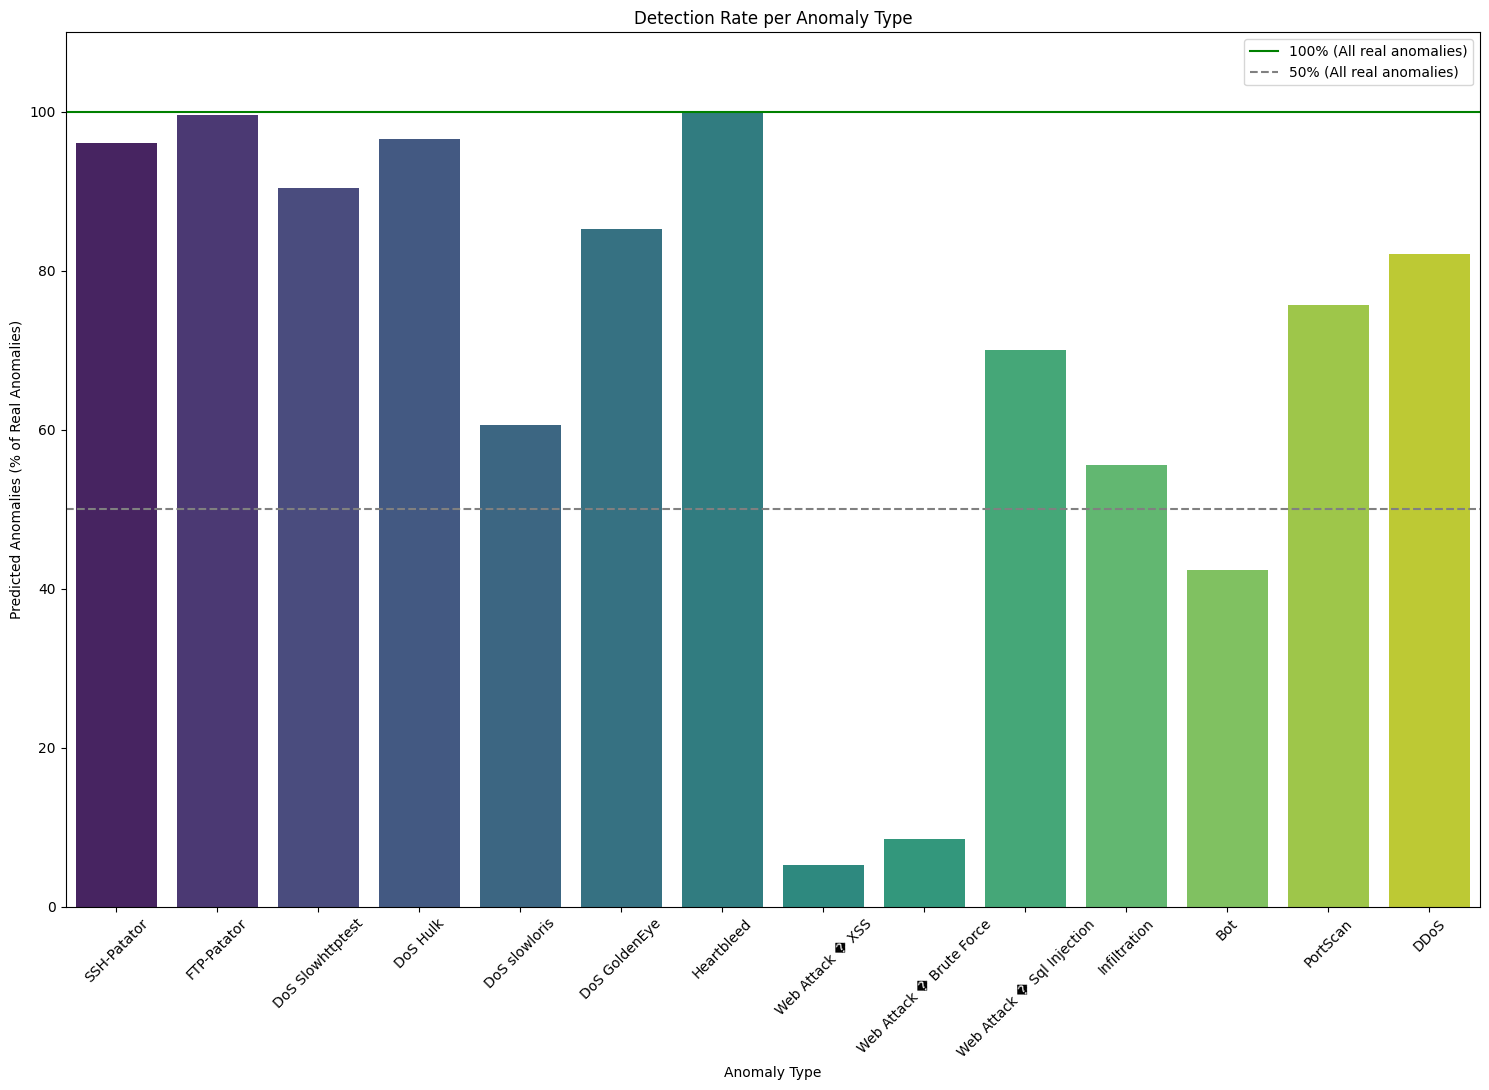

Detection rate by attack type:
Name: SSH-Patator, Detected: 96.0355%
Name: FTP-Patator, Detected: 99.6122%
Name: DoS Slowhttptest, Detected: 90.4725%
Name: DoS Hulk, Detected: 96.5315%
Name: DoS slowloris, Detected: 60.5537%
Name: DoS GoldenEye, Detected: 85.2835%
Name: Heartbleed, Detected: 100.0%
Name: Web Attack � XSS, Detected: 5.2147%
Name: Web Attack � Brute Force, Detected: 8.4793%
Name: Web Attack � Sql Injection, Detected: 70.0%
Name: Infiltration, Detected: 55.5556%
Name: Bot, Detected: 42.3336%
Name: PortScan, Detected: 75.663%
Name: DDoS, Detected: 82.0549%


,IF_prediction,IF_anomaly_score,LOF_prediction,LOF_anomaly_score,AE_prediction,AE_anomaly_score,prediction,anomaly_score,Label
0,1,-0.313946,-1,2.508200,1,0.049511,-1,0.747921,BENIGN
1,1,-0.318780,1,-0.532885,1,0.036191,1,-0.271825,BENIGN
2,1,-0.402547,1,-0.460139,-1,0.258989,-1,-0.201232,BENIGN
3,1,-0.313946,-1,2.449890,1,0.049511,-1,0.728485,SSH-Patator
4,1,-0.331743,1,-0.498932,1,0.078927,1,-0.250583,FTP-Patator
...,...,...,...,...,...,...,...,...,...
1676988,-1,-0.555335,1,-0.162555,1,0.155962,-1,-0.187309,BENIGN
1676989,-1,-0.555458,1,-0.162014,1,0.156062,-1,-0.187137,BENIGN
1676990,1,-0.440034,-1,1.685218,1,0.054260,-1,0.433148,BENIGN
1676991,1,-0.404131,1,-0.504959,1,0.099845,1,-0.269748,BENIGN


In [16]:
# Rename IF columns
df_outliers = df_scaled_result_check_IF[["prediction", "anomaly_score"]]
df_outliers.rename(columns={'prediction': 'IF_prediction', "anomaly_score": "IF_anomaly_score"}, inplace=True)

# Add LOF columns
df_outliers[["LOF_prediction", "LOF_anomaly_score"]] = df_scaled_result_check_LOF[["prediction", "anomaly_score"]]

# Add AE columns
df_outliers[["AE_prediction", "AE_anomaly_score"]] = df_scaled_result_check_AF[["prediction", "anomaly_score"]]

# Calculate final prediction and average anomaly score
df_outliers["prediction"] = df_outliers.apply(
    lambda row: -1 if (row["IF_prediction"] == -1 or row["LOF_prediction"] == -1 or row["AE_prediction"] == -1) else 1,
    axis=1
)

df_outliers["anomaly_score"] = df_outliers[["IF_anomaly_score", "LOF_anomaly_score", "AE_anomaly_score"]].mean(axis=1)

df_outliers[["Label"]] = df_scaled_result_check_LOF[["Label"]]


funs.test_model(name="df_test_all", level=["start","Autoencoder"],ready = df_outliers, flag = True)